# Having fun with py-starbound

## Imports:

In [1]:
import glob
import starbound as sb

import pandas as pd
import seaborn as sns

## Setting the file source

In [2]:
import configparser

config: configparser.ConfigParser = configparser.ConfigParser()
config.read("config.ini")

starbound_src_folder: str = config.get('src', 'folder')
player_folder: str = f"{starbound_src_folder}/storage/player"
universe_folder: str = f"{starbound_src_folder}/storage/universe"

## Working with character files:

We first load the characters into an *global* array to not need to redo the file operations every time.

In [3]:
players: list[sb.VersionedJSON] = []
player_files = list(glob.iglob(f"{player_folder}/*.player", recursive=True))

for file in player_files:
	with open(file, 'r+b') as fh:
		player: sb.VersionedJSON = sb.read_sbvj01(fh)
		players.append(player)

### Now a very simple operation to print a specific string to get the characters:

In [ ]:
from utils import playtime_to_string

characters = []

for player in players:
	name: str = player.data['identity']['name']
	gender: str = player.data['identity']['gender']
	species: str = player.data['identity']['species']
	playtime = playtime_to_string(player.data['log']['playTime'])

	characters.append({"gender": gender, "species": species.title(), "name": name, "playtime": playtime})

pd.DataFrame(characters)

,gender,species,name,playtime
0,female,Novakid,Jane,"2 hours, 10 minutes, 3 seconds, 7803467 millis..."
1,female,Human,Marisa,"26 seconds, 26667 milliseconds"
2,male,Avian,Noxoch,"1 hour, 25 minutes, 51 seconds, 5151984 millis..."
3,female,Apex,Myranda,"4 hours, 19 minutes, 47 seconds, 15587651 mill..."
4,female,Hylotl,Shrine Maiden,"4 hours, 15 minutes, 28 seconds, 15328467 mill..."
5,female,Human,Lilly,"153 hours, 44 minutes, 36 seconds, 553476062 m..."
6,male,Hylotl,Noboru,"66 hours, 0 minutes, 39 seconds, 237639379 mil..."
7,female,Floran,Ru,"1 hour, 26 minutes, 8 seconds, 5168667 millise..."
8,male,Glitch,Stormlord,"39 hours, 15 minutes, 57 seconds, 141357807 mi..."


### Dumping the JSON Data into a json file:

In [9]:
import json

for player in players:
	name: str = player.data['identity']['name']
	with open(f'characters/{name}.json', 'w', encoding='utf-8') as f:
		json.dump(player.data, f, ensure_ascii=False, indent=4)

## Working with world files:

We first load the worlds into an *global* array to not need to redo the file operations every time.

In [ ]:
import mmap

worlds: list[sb.World] = []

world_files = list(glob.iglob(f"{universe_folder}/*_*_*.world", recursive=True))
for file in world_files:
	with open(file, 'r+b') as fh:
		mm: mmap = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)
		world: sb.World = sb.World(mm)
		world.read_metadata()
		worlds.append(world)

### Printing all the important world details

In [20]:
# from utils import strip_colors

# for world in worlds:
# 	print(f'World Name: {strip_colors(world.info.name)}')
# 	print(f'World size: {world.width}×{world.height}')
# 	print(f'World Description: {world.info.description}')
# 	print(80 * '-')

### Getting the Amount of dungeons

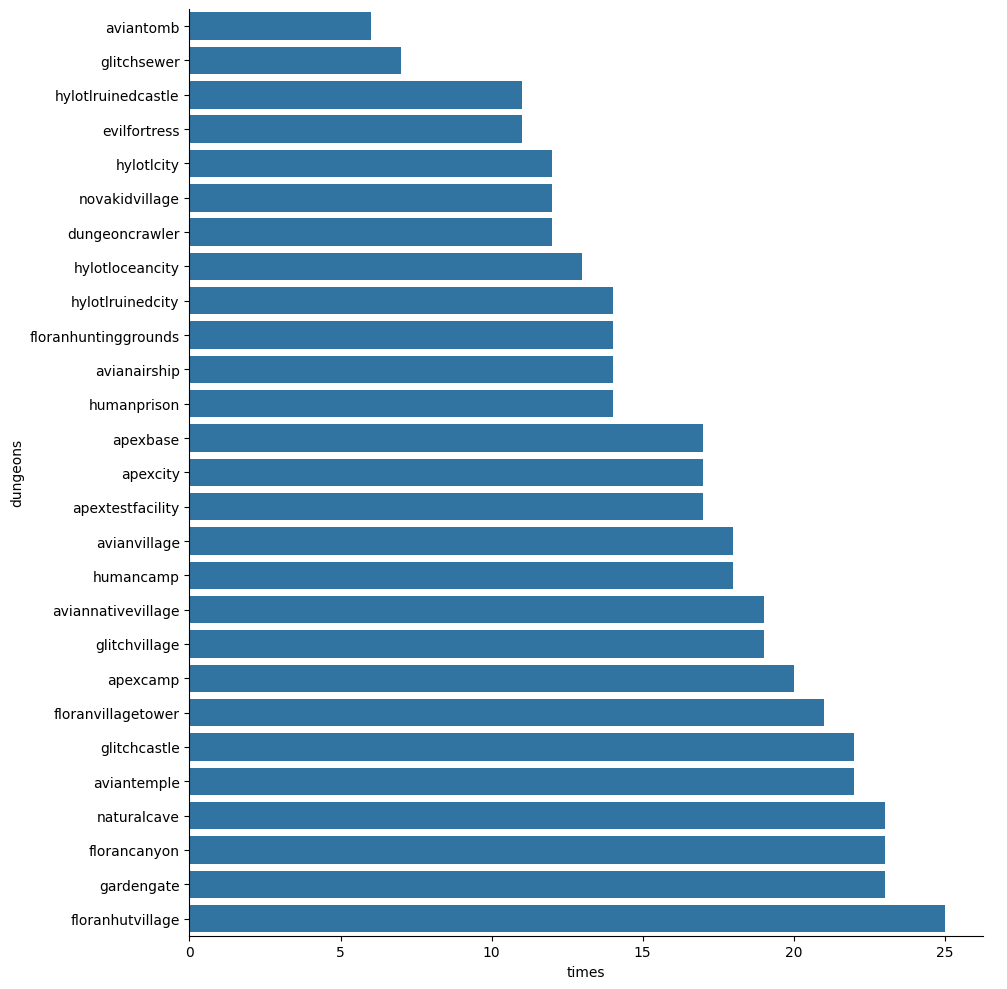

In [21]:
known_dungeons: dict[str, int] = {}

for world in worlds:
	dungeons: list[str] = world.info.dungeons
	# print(strip_colors(world.info.name), ":", dungeons)
	for dungeon in dungeons:
		if dungeon in known_dungeons:
			known_dungeons[dungeon] = known_dungeons[dungeon] + 1
		else:
			known_dungeons[dungeon] = 1

dungeons = pd.Series(data=known_dungeons).explode().reset_index(name="times").rename(columns={"index": "dungeons"}).sort_values("times")

sns.catplot(
	data=dungeons,
	kind="bar",
	x="times",
	y="dungeons",
	height=10
)

### Getting the Amount of biomes

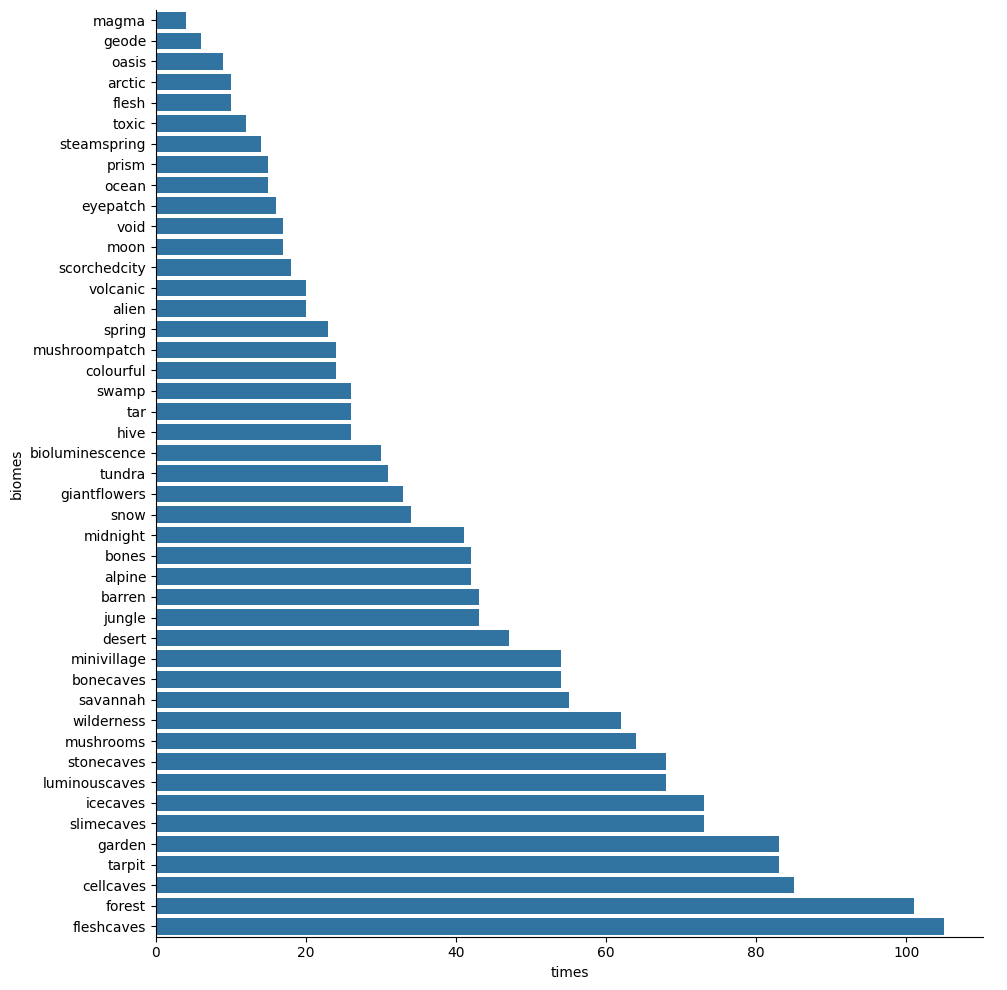

In [22]:

known_biomes: dict[str, int]  = {}

for world in worlds:
	biomes: list[str] = world.info.biomes
	for biome in biomes:
		if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
			continue
		if biome in known_biomes:
			known_biomes[biome] = known_biomes[biome] + 1
		else:
			known_biomes[biome] = 1

biomes = pd.Series(data=known_biomes).explode().reset_index(name="times").rename(columns={"index": "biomes"}).sort_values("times")

sns.catplot(
	data=biomes,
	kind="bar",
	x="times",
	y="biomes",
	height=10
)

### Some world testing

In [23]:
# from utils import strip_planet_number, list_to_str
# star_systems = {}

# for world in worlds:
# 	star_name = strip_planet_number(world.info.name)
# 	if star_name in star_systems:
# 		star_systems[star_name].append(world.info.description)
# 	else:
# 		star_systems[star_name] = [world.info.description]

# for (system, level) in star_systems.items():
# 	print(system, "has:", list_to_str(level, ", "))

### printing the names of where the biomes are and their location

In [24]:
# from utils import strip_colors

# locations: dict[list[tuple[str, tuple[int, int]]]] = {}

# for world in worlds:
# 	biomes: list[str] = world.info.biomes
# 	for biome in biomes:
# 		if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
# 			continue
# 		if biome in locations:
# 			locations[biome].append((strip_colors(world.info.name), (world.info.coords[0], world.info.coords[1])))
# 		else:
# 			locations[biome] = [(strip_colors(world.info.name), (world.info.coords[0], world.info.coords[1]))]

# print(locations)
# for loc in locations:
# 	print(loc)
# 	for n,_ in locations[loc]:
# 		print(4*" ", n)

## Printing csv files to use in a spreadsheet program

### starting with the dungeon data

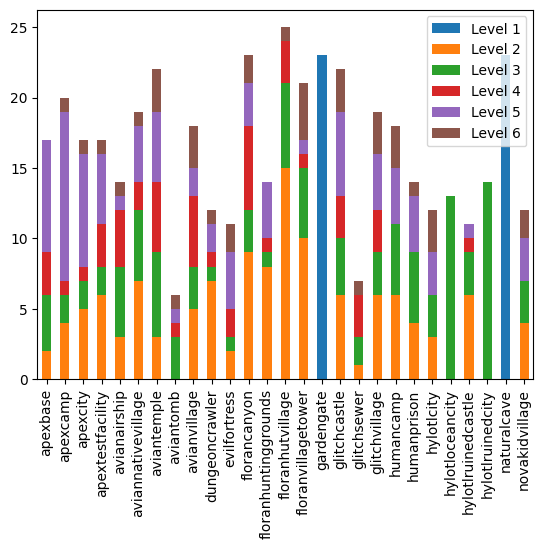

In [25]:
known_dungeons: dict[str, tuple[str, dict[str, int]]] = {}

for world in worlds:
    dungeons: list[str] = world.info.dungeons
    tier: str = world.info.description.split()[1]
    if tier not in ["1", "2", "3", "4", "5", "6"]:
        continue
    for dungeon in dungeons:
        if dungeon in known_dungeons:
            if f"Level {tier}" in known_dungeons[dungeon]:
                known_dungeons[dungeon][f"Level {tier}"] = known_dungeons[dungeon][f"Level {tier}"] + 1
            else:
                known_dungeons[dungeon][f"Level {tier}"] =  1
        else:
            known_dungeons[dungeon] = {"Level 1": 0, "Level 2": 0, "Level 3": 0, "Level 4": 0, "Level 5": 0, "Level 6": 0}
            known_dungeons[dungeon][f"Level {tier}"] = 1

dungeons = pd.DataFrame.from_dict(data=known_dungeons).transpose().sort_index()

dungeons.plot(kind="bar", stacked=True)

dungeons = dungeons.reset_index().rename(columns={"index": "Dungeons"})
dungeons.to_csv('spreadsheet/dungeons.csv', index=False)

### further with the biome data

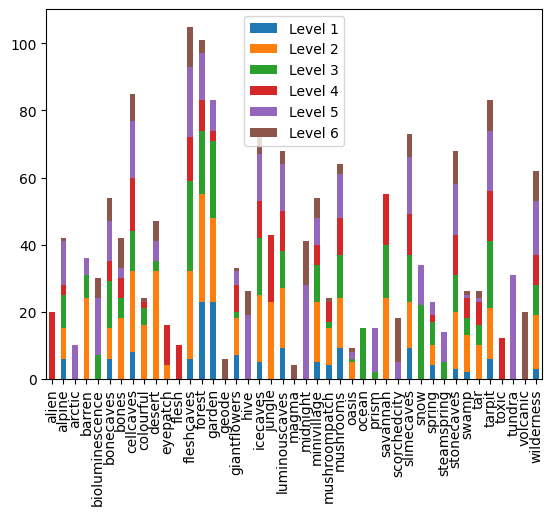

In [26]:
known_biomes: dict[str, int]  = {}

for world in worlds:
    biomes: list[str] = world.info.biomes
    tier: str = world.info.description.split()[1]
    if tier not in ["1", "2", "3", "4", "5", "6"]:
        continue
    for biome in biomes:
        if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
            continue
        if biome in known_biomes:
            if f"Level {tier}" in known_biomes[biome]:
                known_biomes[biome][f"Level {tier}"] = known_biomes[biome][f"Level {tier}"] + 1
            else:
                known_biomes[biome][f"Level {tier}"] =  1
        else:
            known_biomes[biome] = {"Level 1": 0, "Level 2": 0, "Level 3": 0, "Level 4": 0, "Level 5": 0, "Level 6": 0}
            known_biomes[biome][f"Level {tier}"] = 1

biomes = pd.DataFrame.from_dict(data=known_biomes).transpose().sort_index()

biomes.plot(kind="bar", stacked=True)

biomes = pd.DataFrame.from_dict(data=known_biomes).transpose().sort_index().reset_index().rename(columns={"index": "Biomes"})
biomes.to_csv('spreadsheet/biomes.csv', index=False)